In [1]:
from math import sqrt

import numpy as np

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import skimage
from skimage import io, exposure, img_as_float, img_as_ubyte, morphology, filters, util
from skimage.color import rgb2gray, label2rgb
from skimage.feature import canny, blob_dog, blob_log, blob_doh,  peak_local_max
from skimage.filters import sobel, threshold_otsu, try_all_threshold, threshold_local, threshold_minimum
from skimage.segmentation import clear_border, watershed, random_walker
from skimage.measure import label, regionprops
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage.morphology import closing
from skimage.io import imsave, imread

import cv2

from scipy import ndimage as ndi
from scipy.stats import norm

import os

import plotly.graph_objs as go

import platform

In [2]:
#image_filename = '/Users/carolinemccue/Desktop/MG63/r01c02f26p03-ch2sk1fk1fl1.tiff'
#image_filename = '/Users/carolinemccue/Desktop/MG63/r01c02f24p04-ch2sk1fk1fl1.tiff'
image_filename = '/Users/carolinemccue/Desktop/MG63/r01c02f10p04-ch2sk1fk1fl1.tiff'

#image_filename = '/Users/carolinemccue/Desktop/MG63/r01c02f11p02-ch2sk1fk1fl1.tiff'

if os.path.isdir(image_filename):
    img_list = [os.path.join(image_filename,f) for f in os.listdir(image_filename) if f.endswith('.jpg')]
elif os.path.isfile(image_filename):
    img_list = [image_filename]

for image_file in img_list:
        image = cv2.imread(image_file, 0)

In [3]:
x = 0
out_directory = "MG635_" + str(x)
while os.path.exists(out_directory):
    x = int(os.path.basename(out_directory).split('_')[1])
    x += 1
    out_directory = "MG635_" + str(x)
os.mkdir("MG635_" + str(x))

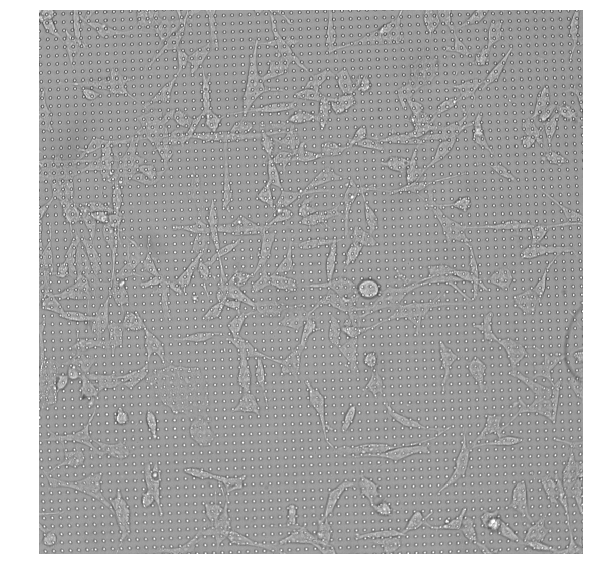

In [4]:
fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(image, cmap=plt.cm.gray, vmin=0, vmax=255, interpolation='nearest')

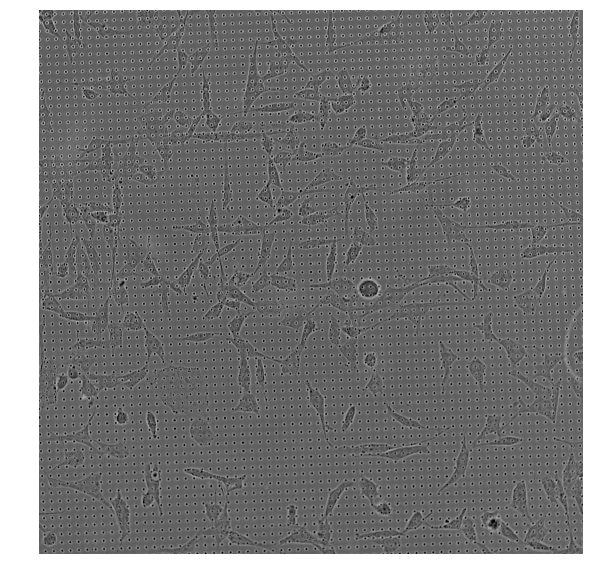

In [5]:
image = np.invert(image)
fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(image, cmap=plt.cm.gray, vmin=0, vmax=255, interpolation='nearest')

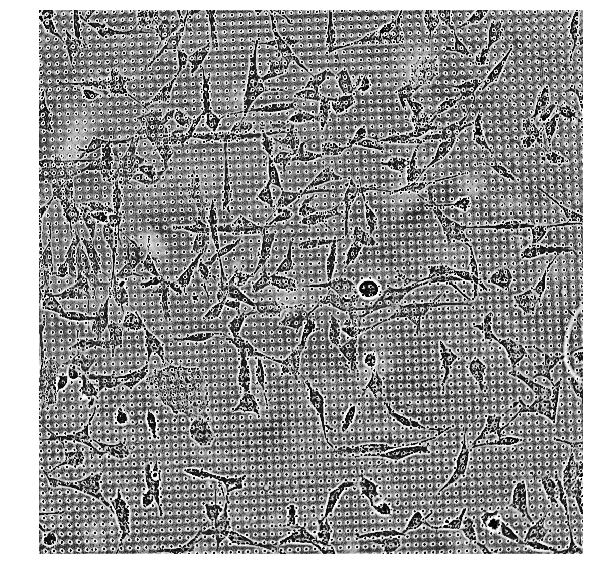

In [6]:
# Adaptive Equalization
clahe = cv2.createCLAHE(clipLimit=20, tileGridSize=(10,10))
img_adapteq = clahe.apply(image)
fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img_adapteq, cmap=plt.cm.gray, interpolation='nearest')

Minimum threshold: 65.0
Min intensity: 0
Max intensity: 255


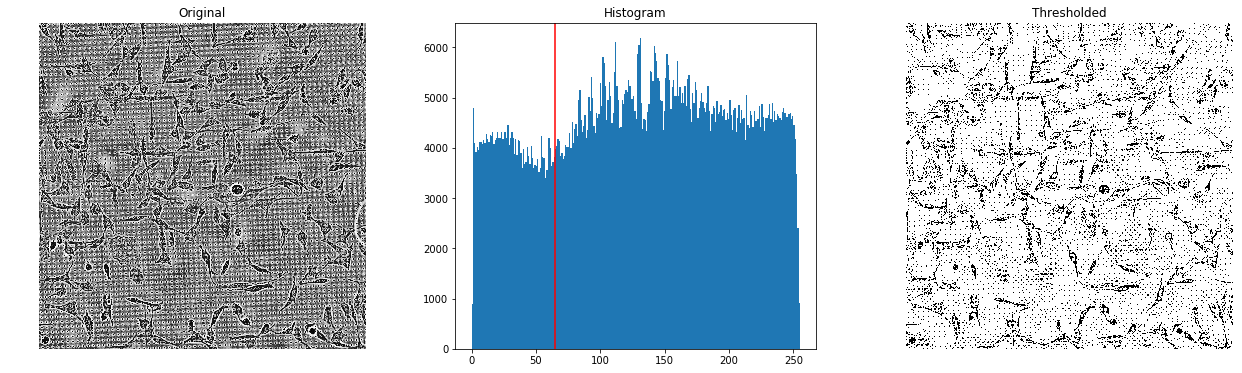

In [7]:
image = img_adapteq

blur = cv2.GaussianBlur(image,(3,3),0)
retVal, binary = cv2.threshold(blur,65,255,cv2.THRESH_BINARY)

fig, axes = plt.subplots(ncols=3, figsize=(22, 6))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(retVal, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

print('Minimum threshold: ' + str(retVal))
print('Min intensity: ' + str(np.min(image)))
print('Max intensity: ' + str(np.max(image)))
plt.show()

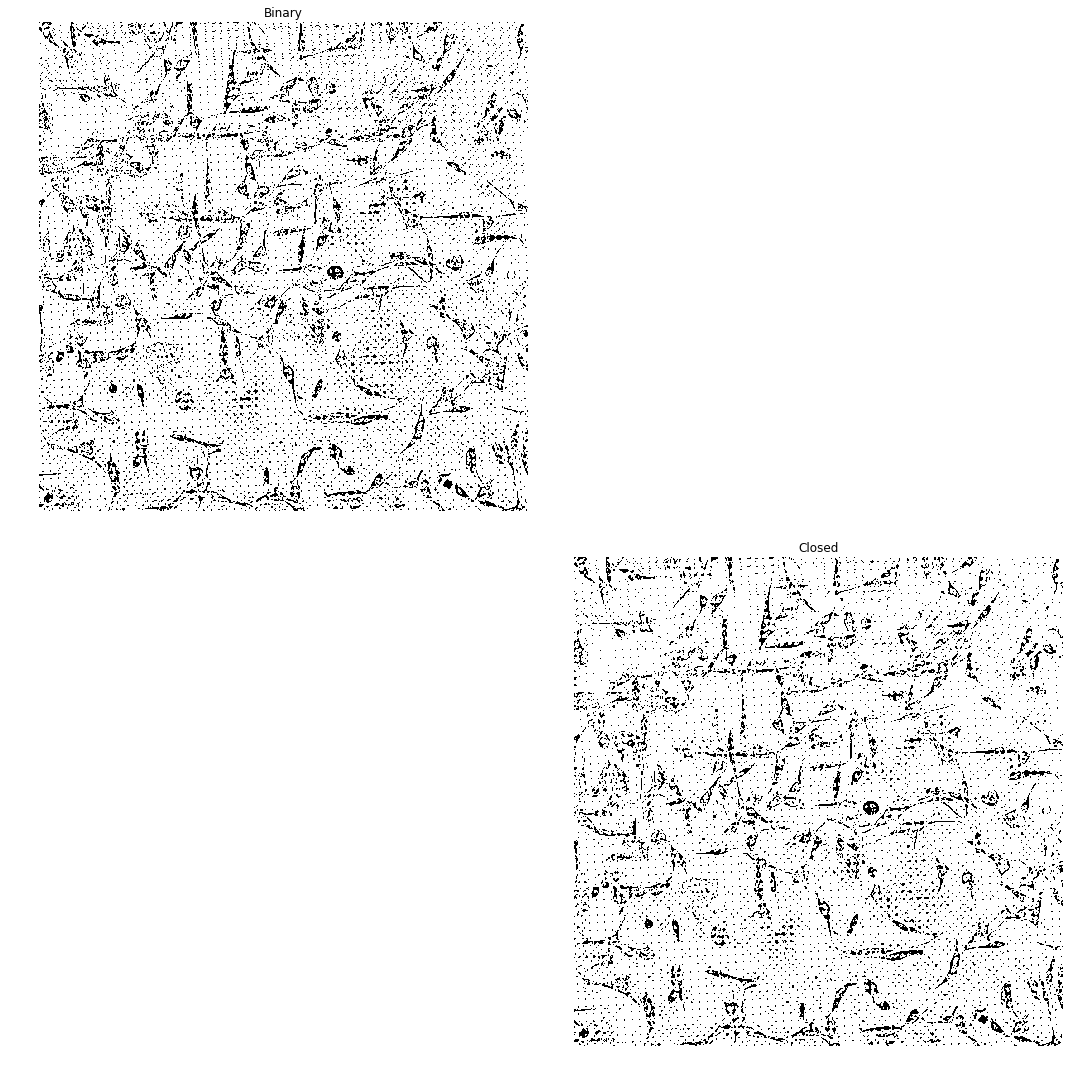

In [8]:
from skimage.morphology  import binary_closing, disk, binary_dilation, remove_small_holes, remove_small_objects
#fill_holes = ndi.morphology.binary_fill_holes(binary, structure=np.ones((15,15))).astype('uint8')

#remove_posts = morphology.remove_small_objects(binary, 85)
#remove_posts = morphology.remove_small_holes(remove_posts, 85)
#remove_posts = remove_posts.astype(np.uint8)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2))
closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations = 1)


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(binary, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Binary')
#ax[1].imshow(fill_holes, cmap=plt.cm.gray, interpolation='nearest')
#ax[1].set_title('Fill Holes')
#ax[2].imshow(remove_posts, cmap=plt.cm.gray, interpolation='nearest')
#ax[2].set_title('Removed posts')
ax[3].imshow(closed, cmap=plt.cm.gray, interpolation='nearest')
ax[3].set_title('Closed')


for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()
#plt.savefig("2_thresh_close.jpg")

In [9]:
binary=np.invert(binary)

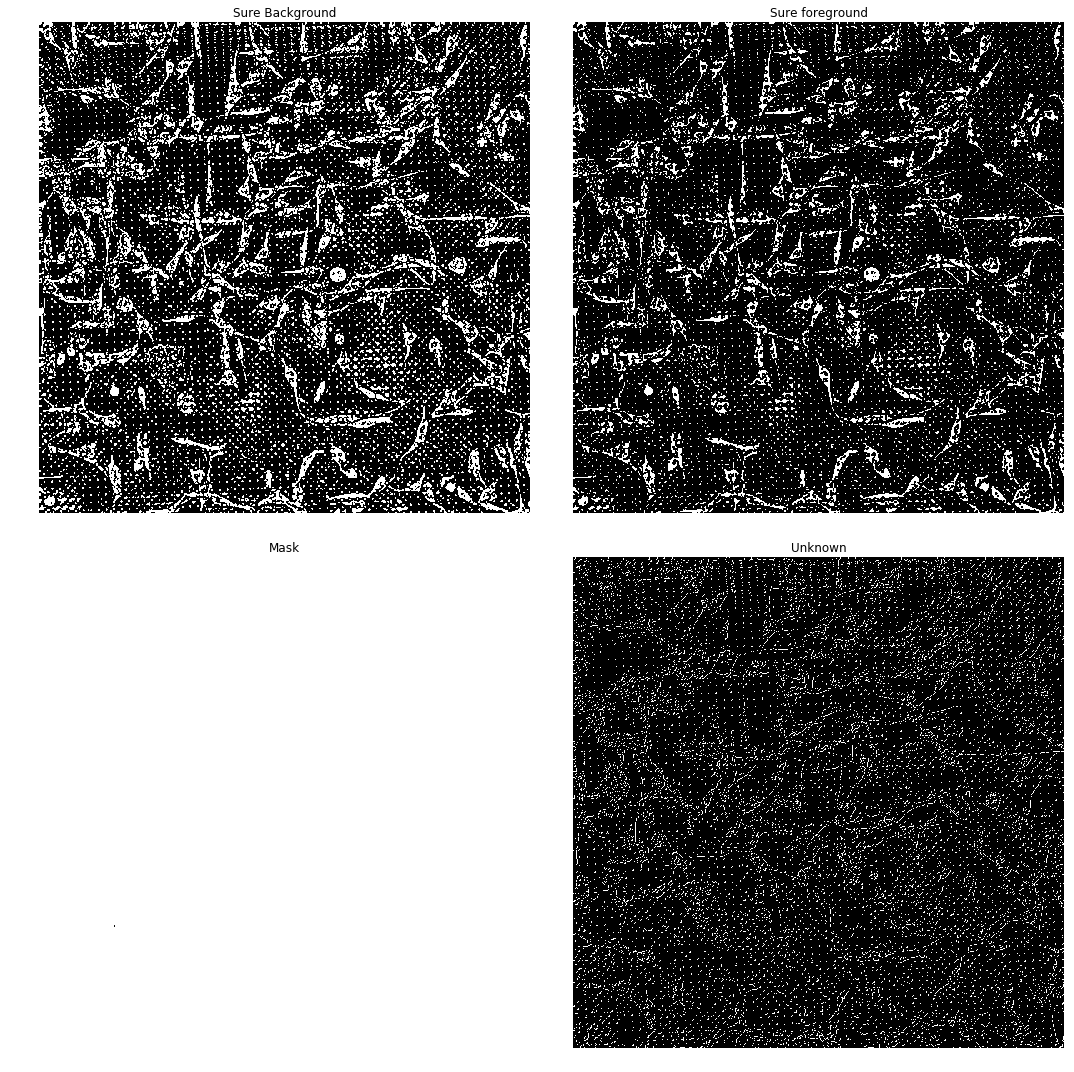

In [10]:
# noise removal
kernel = np.ones((2,2),np.uint8)
#opening = cv2.morphologyEx(closed,cv2.MORPH_OPEN,kernel, iterations = 2)
closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations = 2)
# sure background area
#sure_bg = cv2.dilate(opening,kernel,iterations=3)
sure_bg = cv2.dilate(closing,kernel,iterations=1)
# Finding sure foreground area
#dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
dist_transform = cv2.distanceTransform(closing,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.1*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

mask = dist_transform.copy()
mask[mask < 8] = 0

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(sure_bg, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Sure Background')
ax[1].imshow(sure_fg, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Sure foreground')
ax[2].imshow(-mask, cmap=plt.cm.gray, interpolation='nearest')
ax[2].set_title('Mask')
ax[3].imshow(unknown, cmap=plt.cm.gray, interpolation='nearest')
ax[3].set_title('Unknown')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

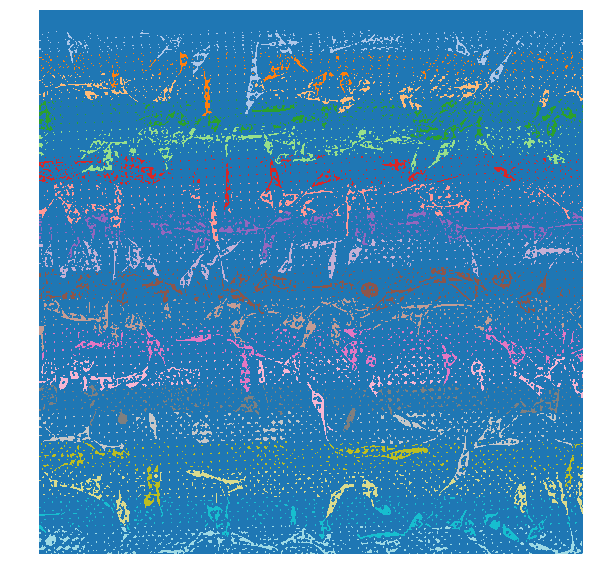

In [11]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

markers = markers+1
markers[unknown>0] = 0

fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(markers, cmap=plt.cm.tab20)

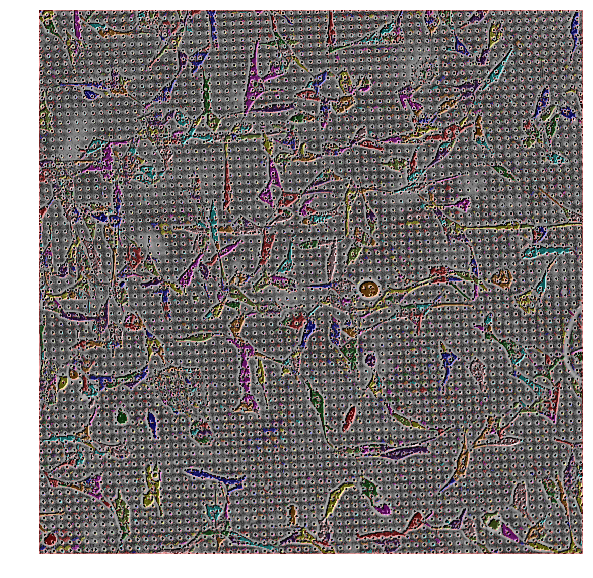

In [12]:
threeChannels = cv2.cvtColor(closed, cv2.COLOR_GRAY2BGR)
segmented = cv2.watershed(threeChannels.astype('uint8'), markers)

# Color the labels sections for display
image_label_overlay = label2rgb(segmented, image, bg_label=1)
fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(image_label_overlay)

In [13]:
reg = regionprops(segmented, intensity_image=image)[1:]
cellreg = [region for region in reg if (region.area) > 100 and (region.area) < 25000]
columns= ['Label', 'Area', 'Eccentricity', 'Circularity', 'Bbox Area', 'Bbox', 'Centroid', 'Image', 'Long Axis', 'Short Axis']
df = pd.DataFrame(columns=columns, dtype=np.float64)
df = df.append([{'Label':i.label, 'Area':i.area, 'Eccentricity':i.eccentricity, 'Circularity':(4 * np.pi * i.area / (i.perimeter**2)), 'Bbox Area':i.bbox_area, 'Bbox':i.bbox, 'Centroid':i.centroid, 'Image':i.intensity_image, 'Long Axis':i.major_axis_length, 'Short Axis':i.minor_axis_length} for i in cellreg])
df.head(5)

Label   Area  Eccentricity  Circularity  Bbox Area               Bbox  \
0    3.0  202.0      0.337727     0.265555  1166400.0     (1, 8, 20, 30)   
1    4.0  410.0      0.986546     0.223156  1166400.0    (1, 71, 58, 83)   
2   11.0  111.0      0.910056     0.536901  1166400.0  (1, 303, 12, 321)   
3   12.0  440.0      0.985016     0.182737  1166400.0  (1, 334, 61, 354)   
4   25.0  197.0      0.837444     0.176109  1166400.0  (1, 796, 29, 818)   

                                  Centroid  \
0  (7.866336633663367, 18.925742574257427)   
1  (29.602439024390243, 76.21463414634147)   
2  (4.4774774774774775, 310.5045045045045)   
3   (25.68409090909091, 345.0204545454545)   
4  (11.203045685279188, 809.8223350253808)   

                                               Image  Long Axis  Short Axis  
0  [[0, 0, 0, 16, 16, 21, 17, 21, 30, 24, 13, 16,...  22.855092   21.512220  
1  [[0, 30, 38, 33, 19, 31, 197, 0, 0, 0, 0, 0], ...  61.871181   10.114863  
2  [[0, 18, 27, 77, 0, 0, 0, 28, 36, 54, 30, 22, ...  20.539206    8.513220  
3  [[24, 39, 143, 0, 0, 0, 7, 20, 144, 58, 0, 0, ...  72.309718   12.470740  
4  [[0, 0, 51, 88, 72, 0, 0, 0, 0, 0, 8, 18, 43, ...  35.478113   19.389586

In [14]:
df['Area'].median(), df['Area'].mean()

(241.0, 287.2807570977918)

317 cells were detected and segmented
175 cells with selected criteria


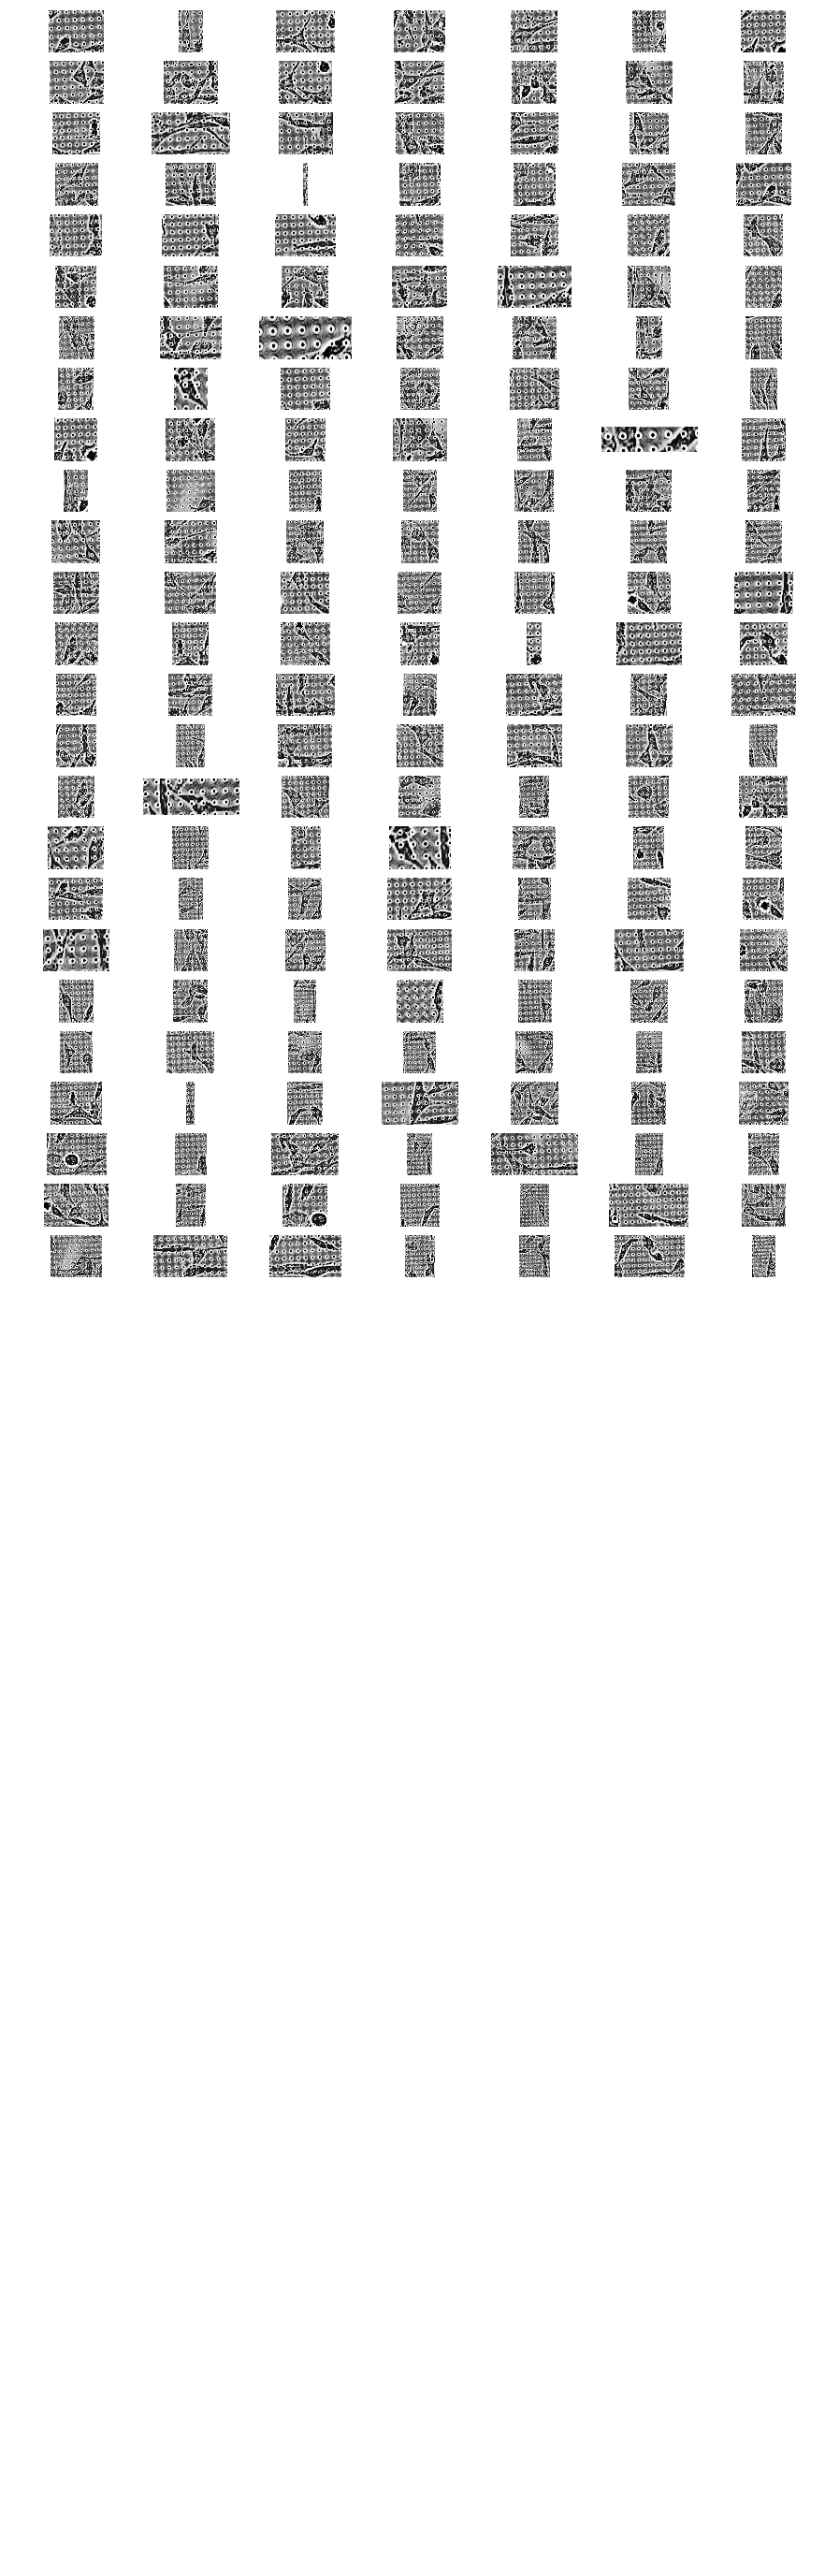

In [15]:
# Display parameters
org_img = image # Intensity image
border = 75 # Additional pixels to display on each side of the bounding box
ecc_cutoff = 0.05 # circularity cuttoff, removes background circles
ecc_cutoff_upper = 1
area_cutoff_upper = 5*df.Area.mean() # Area cuttoff, removes misidentified shapes (for instance half-droplets)
area_cutoff_lower = 0.9*df.Area.median()
max_col = org_img.shape[1]
max_row = org_img.shape[0]

n_img = len(cellreg)
print("{} cells were detected and segmented".format(n_img))
n_col = 50
n_rows = n_img // n_col + 1

cellreg.sort(key=lambda x: x.area)
cellreg_clean = [region for region in cellreg if (region.area) > area_cutoff_lower and (region.area) < area_cutoff_upper and region.eccentricity > ecc_cutoff and region.eccentricity < ecc_cutoff_upper]

print("{} cells with selected criteria".format(len(cellreg_clean), area_cutoff_lower, area_cutoff_upper))

fig, ax = plt.subplots(n_col, n_rows)
axes = ax.ravel()

for i, region in enumerate(cellreg_clean):
    (min_row, min_col, max_row, max_col) = region.bbox
    drop_image = org_img[np.max([min_row-border,0]):np.min([max_row+border,max_row]),np.max([min_col-border,0]):np.min([max_col+border,max_col])]
    contrast_stretch = exposure.rescale_intensity(drop_image, in_range=(0,255))
    name = os.path.join(out_directory, os.path.basename(image_file).split('.')[0] + '_cell_' + str(i) + '.jpg')
    imsave(name, contrast_stretch, check_contrast=False)
    axes[i].imshow(contrast_stretch, cmap=plt.cm.gray, interpolation='nearest', vmin=0, vmax=255)
    axes[i].axis('off')
    
for i in range(n_col*n_rows - len(cellreg_clean)):
    axes[-(i+1)].axis('off')
    
fig.set_size_inches(15, 50)

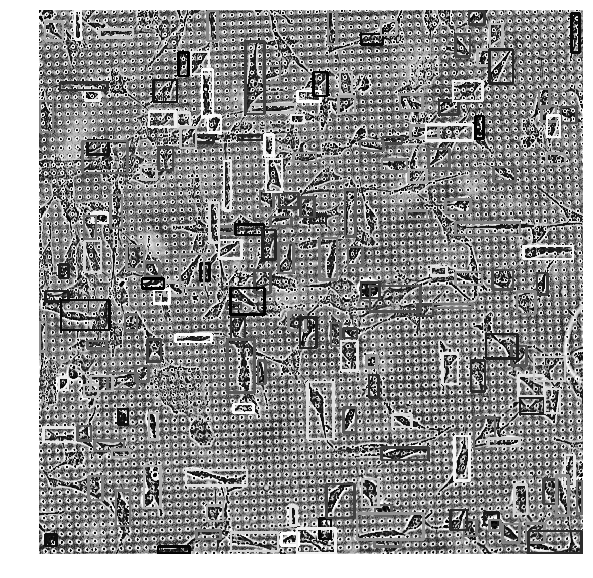

In [20]:
boxed_regions = image.copy()
for region in cellreg_clean:
    (min_row, min_col, max_row, max_col) = region.bbox
    color = np.uint8(np.random.randint(0, 255, 3)).tolist()
    cv2.rectangle(boxed_regions, (min_col,min_row), (max_col,max_row), color, 3)
    #cv2.putText(boxed_regions,'%d'%region.label,(min_col+50, min_row+100), cv2.FONT_HERSHEY_SIMPLEX, 3, color, 3, cv2.LINE_AA)
    
fig = plt.figure(figsize=(15,10))
plt.axis('off')
plt.imshow(boxed_regions, cmap=plt.cm.gray)


In [17]:
columns= ['Label', 'Area', 'Eccentricity', 'Circularity', 'Bbox Area', 'Bbox', 'Centroid', 'Image', 'Long Axis', 'Short Axis']
df2 = pd.DataFrame(columns=columns, dtype=np.float64)
df2 = df2.append([{'Label':i.label, 'Area':i.area, 'Eccentricity':i.eccentricity, 'Circularity':(4 * np.pi * i.area / (i.perimeter**2)), 'Bbox Area':i.bbox_area, 'Bbox':i.bbox, 'Centroid':i.centroid, 'Image':i.intensity_image, 'Long Axis':i.major_axis_length, 'Short Axis':i.minor_axis_length} for i in cellreg_clean])
df2.tail(5)

Label    Area  Eccentricity  Circularity  Bbox Area  \
170  6644.0   915.0      0.982710     0.090197  1166400.0   
171  6901.0   934.0      0.906365     0.079766  1166400.0   
172  5111.0  1004.0      0.955310     0.049326  1166400.0   
173  7620.0  1028.0      0.982889     0.069601  1166400.0   
174   614.0  1117.0      0.983186     0.056979  1166400.0   

                      Bbox                                 Centroid  \
170   (868, 679, 893, 773)    (879.1409836065574, 728.824043715847)   
171   (905, 208, 988, 241)     (953.93147751606, 223.8693790149893)   
172   (654, 374, 759, 427)  (702.8804780876494, 407.98107569721117)   
173  (999, 631, 1051, 763)  (1031.0048638132296, 710.6264591439689)   
174    (62, 409, 206, 447)  (144.8218442256043, 424.16830796777083)   

                                                 Image   Long Axis  Short Axis  
170  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   97.102304   17.978588  
171  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 16, 178, 0...   85.084571   35.947767  
172  [[8, 15, 31, 31, 25, 24, 25, 22, 0, 0, 0, 0, 0...  122.818676   36.306023  
173  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  160.573785   29.577929  
174  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  139.879721   25.543068

In [18]:
areaum5 = df2['Area'] / 1.5503 ** 2
celllength5 = df2['Long Axis'] / 1.5503
circularity5 = df2['Circularity']
aspectratio5 = df2['Short Axis']/df2['Long Axis']
areaum5.mean(), areaum5.std()

(166.93998011341014, 75.88649212505214)

In [19]:
%store areaum5
%store circularity5
%store celllength5
%store aspectratio5

Stored 'areaum5' (Series)
Stored 'circularity5' (Series)
Stored 'celllength5' (Series)
Stored 'aspectratio5' (Series)
